# RecSys
Modelo do tipo recuperação

## Importando bibliotecas necessárias

In [1]:
from sklearn import model_selection, preprocessing
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import torch

Configurando dispositivo para utilizar GPU se possível; caso contrário, CPU

In [2]:
mode = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(mode)
device

device(type='cuda')

In [3]:
torch.set_default_device(device)

In [4]:
generator = torch.Generator(device)

## Carregando dados do dataset de avaliações de filmes

In [5]:
class OlistReviews(Dataset):
    '''
    Classe criada com o intuito de ajustar o dataset pandas ao
    treinamento de modelos utilizando o PyTorch, especialmente do que se
    diz respeito à utilização de lotes (batches) durante o treinamento.
    '''
    def __init__(self, dataset_path: str, device: torch.device):
        """
        Construtor da classe, responsável por ler os dados e organizar os dados
        """
        self.device = device

        dataset = pd.read_csv(dataset_path, sep=',')

        labelEncoder = preprocessing.LabelEncoder()
        self.customers = labelEncoder.fit_transform(dataset['customer_id'].values)
        self.products = labelEncoder.fit_transform(dataset['product_id'].values)
        self.products_categories = labelEncoder.fit_transform(dataset['product_category'].values)

        standardScaler = preprocessing.StandardScaler()
        scaled = standardScaler.fit_transform(dataset.loc[:, ['latitude', 'longitude']])
        self.latitudes = scaled[:, 0]
        self.longitudes = scaled[:, 1]

        self.reviews = self.__preprocess_review(dataset['review_score']).values

        self.n_unique_customer = len(np.unique(self.customers))

    def __len__(self) -> int:
        """
        Retorna o número de avaliações do conjunto de dados
        """
        return self.reviews.shape[0]

    def __getitem__(self, item) -> dict[torch.tensor]:
        """
        Retorna itens do conjunto de dados em lotes
        """
        customers = self.customers[item]
        latitudes = self.latitudes[item]
        longitudes = self.longitudes[item]
        products = self.products[item]
        products_categories = self.products_categories[item]
        reviews = self.reviews[item]

        return {
            "customers": torch.tensor(customers, device=self.device, dtype=torch.long),
            "latitudes": torch.tensor(latitudes, device=self.device, dtype=torch.float64),
            "longitudes": torch.tensor(longitudes, device=self.device, dtype=torch.float64),
            "products": torch.tensor(products, device=self.device, dtype=torch.long),
            "products_categories": torch.tensor(products_categories, device=self.device, dtype=torch.long),
            "reviews": torch.tensor(reviews, device=self.device, dtype=torch.int8),
        }

    def __preprocess_review(self, reviews: pd.Series) -> pd.Series:
        """
        Preprocessa as avaliações dos clientes entre amostradas positivas e
        negativas
        """
        reviews = reviews.map(lambda review: 1 if review > 4 else 0)
        return reviews

In [6]:
df_olist_reviews = OlistReviews('./data/rfzd_olist_products_reviews.csv', device)

In [7]:
pd.Series(df_olist_reviews.reviews).value_counts()

1    58394
0    43748
Name: count, dtype: int64

## Preprocessamento dos dados para a geração de embeddings

Dividindo dataset entre conjunto de treinamento, validação e teste

In [8]:
dataset_length = len(df_olist_reviews)

train_length = int(dataset_length * 0.7)
valid_length = int(dataset_length * 0.15)
test_length  = dataset_length - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset=df_olist_reviews,
    lengths=(train_length, valid_length, test_length),
    generator=generator
)

Ajustando dataset para ser utilizado pelo PyTorch como um iterável que retorna lotes de dados a cada iteração

In [9]:
BATCH_SIZE = 8

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Após isso, toda vez que o DataLoader for requisitado, ele retornará um lote (batch) de 8 itens

In [11]:
dataiter = iter(train_loader)
next(dataiter)

{'customers': tensor([46720,  8354, 10651, 34384, 29180, 54009, 44020, 47373],
        device='cuda:0'),
 'latitudes': tensor([-1.0419, -0.2915,  0.2132, -0.4455,  1.0102, -1.5787,  2.3495,  3.3342],
        device='cuda:0', dtype=torch.float64),
 'longitudes': tensor([-1.1712,  0.7139, -1.0364, -0.1140, -0.2838, -1.2403,  2.7846,  0.2695],
        device='cuda:0', dtype=torch.float64),
 'products': tensor([15290, 30648, 16486,  5619, 24930,  6563,  8942, 17176],
        device='cuda:0'),
 'products_categories': tensor([32, 44, 11, 71, 73, 13, 54, 20], device='cuda:0'),
 'reviews': tensor([0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0', dtype=torch.int8)}

## Criando modelo de RecSys

Criando modelo de RecSys no estilo de torre-dupla

In [12]:
class OlistRecSys(nn.Module):
    '''
    Classe criada com o intuito de modelar a estrutura de torre-dupla,
    isto é, um dos modelos clássicos de RecSys baseado em filtragem
    colaborativa por meio de redes neurais.
    '''
    def __init__(self, n_customers, n_products, n_categories, embedding_size = 32):
        super().__init__()
        # definindo embedding para clientes e produtos
        self.customer_embedding = nn.Embedding(n_customers, embedding_size)
        self.products_embedding = nn.Embedding(n_products, embedding_size)
        self.categories_embedding = nn.Embedding(n_categories, embedding_size)
        # definindo camada de saída como um neurônio
        self.output_layer = nn.Linear(embedding_size * 3, 1)

    def forward(self, customers, products, categories):
        # criando camada de entrada a partir de embeddings de clientes e produtos
        customer_embeddings = self.customer_embedding(customers)
        products_embeddings = self.products_embedding(products)
        categories_embedding = self.categories_embedding(categories)
        # concatenando embeddings de clientes e produtos
        concat_embeddings = torch.cat([
            customer_embeddings,
            products_embeddings,
            categories_embedding
        ], dim=1)
        
        output = self.output_layer(concat_embeddings)
        return output

Contando quantidade de clientes e produtos distintos envolvidos em compras

In [13]:
n_customers = len(np.unique(df_olist_reviews.customers))
n_products = len(np.unique(df_olist_reviews.products))
n_categories = len(np.unique(df_olist_reviews.products_categories))
n_customers, n_products, n_categories

(98392, 32904, 74)

Instanciando modelo RecSys, configurando otimizador, taxa de aprendizado e função custo

In [14]:
STEP_SIZE = 4

In [15]:
model = OlistRecSys(n_customers, n_products, n_categories).to(device)

optimizer = torch.optim.Adam(model.parameters())
scheaduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, gamma=0.7)
loss_function = nn.MSELoss()

In [16]:
model

OlistRecSys(
  (customer_embedding): Embedding(98392, 32)
  (products_embedding): Embedding(32904, 32)
  (categories_embedding): Embedding(74, 32)
  (output_layer): Linear(in_features=96, out_features=1, bias=True)
)

Criando o ciclo de treinamento

In [17]:
epochs = 2
total_loss = 0
plot_steps = 5000
step_count = 0
all_losses_list = []

In [18]:
model.to(device).train()

for epoch_index in range(epochs):
    for index, train_data in enumerate(train_loader):
        # calculando tamanho do lote retornado
        batch_length = len(train_data['customers'])
        # predições do modelo (y-predito)
        predictions = model(train_data['customers'], train_data['products'], train_data['products_categories'])
        # reformatando y-verdeiro para fical igual ao formato da saída do modelo y predito
        reviews = train_data['reviews'].view(batch_length, -1).to(torch.float32)
        # calculando o erro do modelo
        loss = loss_function(predictions, reviews)
        # somando erro do modelo ao longo dos passos de treinamento
        total_loss += loss.sum().item()
        # executando ajuste dos pesos no modelo via algoritmo de retropropagação
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # contando quantidade de instâncias utilizadas a cada iteração do treinamento
        step_count += batch_length

        if (step_count % plot_steps == 0):
            average_loss = total_loss / ( batch_length * plot_steps)
            print(f'epoch {epoch_index} loss at step: {step_count} is {average_loss}')
            all_losses_list.append(average_loss)
            total_loss = 0

epoch 0 loss at step: 5000 is 0.005743332931026817
epoch 0 loss at step: 10000 is 0.004058661890029907
epoch 0 loss at step: 15000 is 0.003947560529410839
epoch 0 loss at step: 20000 is 0.003958694157376885
epoch 0 loss at step: 25000 is 0.004020451330393553
epoch 0 loss at step: 30000 is 0.003951936164870858
epoch 0 loss at step: 35000 is 0.0039319354232400655
epoch 0 loss at step: 40000 is 0.003955516429245472
epoch 0 loss at step: 45000 is 0.003966956678032875
epoch 0 loss at step: 50000 is 0.003968925700336695
epoch 0 loss at step: 55000 is 0.003938120325282216
epoch 0 loss at step: 60000 is 0.003930175209790468
epoch 0 loss at step: 65000 is 0.003910900190658867
epoch 0 loss at step: 70000 is 0.003921338637173176


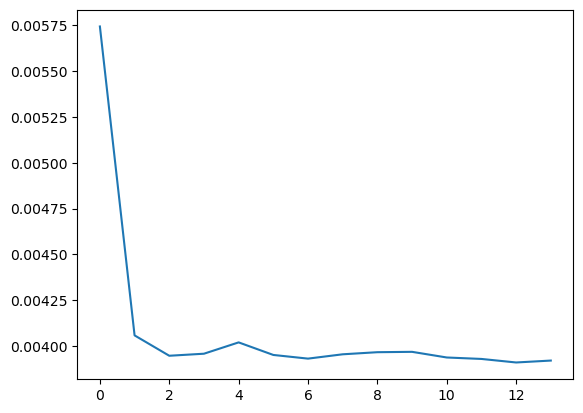

In [20]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

## Avaliando o modelo

Calculando a raiz do erro quadrádico médio

In [38]:
from sklearn.metrics import root_mean_squared_error

model_output_list = []
target_purchase_list = []

model.eval()

with torch.no_grad():

    for index, test_data in enumerate(test_loader):
        # calculando tamanho do lote retornado
        batch_length = len(test_data['customers'])
        # predições do modelo (y-predito)
        output = model(test_data['customers'], test_data['products'])
        # armazenando o erro do modelo
        model_output_list.append(output.sum().item() / batch_length)
        # recuperando valor original (y-verdadeiro)
        target_purchase = test_data['purchases']
        target_purchase_list.append(target_purchase.sum().item() / batch_length)

rms = root_mean_squared_error(target_purchase_list, model_output_list)
rms

4.1627381739597084e-07

precisão e recall dos K-produtos (Precision@K and Recall@K)

In [21]:
from collections import defaultdict

customer_pred_true = defaultdict(list)

with torch.no_grad():

    for i, test_data in enumerate(test_loader):

        customers = test_data['customers']
        products = test_data['products']
        purchases = test_data['purchases']

        output = model(customers, products)

        for j in range(len(customers)):

            customer_id = customers[j].item()
            product_id = products[j].item()

            pred_purchase_count = output[j][0].item()
            true_purchase_count = purchases[j].item()

            customer_pred_true[customer_id].append((pred_purchase_count, true_purchase_count))
            print(f'customer_id: {customer_id}; product_id: {product_id}; true_purchase_count: {true_purchase_count}; pred_purchase_count: {pred_purchase_count}')

KeyError: 'purchases'

In [41]:
with torch.no_grad():

    precisions = dict()
    recalls = dict()

    k=100
    threshold=1

    for uid, customer_purchase_count in customer_pred_true.items():

        # ordenando as predições de produtos comprados por cliente
        customer_purchase_count.sort(key=lambda x: x[0], reverse=True)
        # registrando o número de produtos relevantes
        n_rel = sum((true_p >= threshold) for (_, true_p) in customer_purchase_count)
        # regitrando o número de produtos recomendados que foram preditos como relevantes para o top K produtos
        n_rec_k = sum((pred >= threshold) for (pred, _) in customer_purchase_count[:k])
        # registrando o número de produtos recomendados que são realmente relevantes para o top K produtos
        n_rec_and_rec_k = sum(
            ((true_p >= threshold) and (pred >= threshold))
            for (pred, true_p) in customer_purchase_count[:k]
        )

        print(f'uid: {uid}; n_rel: {n_rel}; n_rec_k: {n_rec_k}; n_rec_and_rec_k: {n_rec_and_rec_k}')

        # proporção de produtos recomendados que são relevantes
        precisions[uid] = n_rec_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # proporção de produtos relevantes que foram recomendados
        recalls[uid] = n_rec_and_rec_k / n_rel if n_rel != 0 else 0

uid: 33398; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 67748; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 90885; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 4262; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 18644; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 58707; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 78814; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 71780; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 75334; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 56265; n_rel: 2; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 73832; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 25921; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 10392; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 67832; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 46436; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 70202; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 78544; n_rel: 1; n_rec_k: 0; n_rec_and_rec_k: 0
uid: 65704; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 67233; n_rel: 1; n_rec_k: 0; n_rec_and_rec

In [42]:
print(f'Precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}')
print(f'Recall @ {k}: {sum(rec for rec in recalls.values()) / len(recalls)}')

Precision @ 100: 0.47453688334107963
Recall @ 100: 0.4736405285173627
